Ajustes feitos na versão inicial(completa):
    Retirar parágrafos que não impactaram positivamente na busca: nota_escopo (piora os resultados) e tem_especializacao e tem_generalizacao (não ajudam e podem atrapalhar)
    Aumentar ocorrência do termo principal (O Termo é xxx. Xxxx tem os seguintes sinônimos. XXX tem ....)

Salvar dataframes em disco para, em próximas cargas, não trazer dados atualizados que impactam as métricas de comparação.

Criar bases com nome: vce_relevancia_xxxx

# Imports 

In [1]:
from collections import Counter

In [2]:
import pandas as pd

In [3]:
import re

In [4]:
import numpy as np


In [5]:
from tqdm import tqdm

In [6]:
import os

In [7]:
import csv

In [31]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import seaborn as sns


In [8]:
import json

In [9]:
%%time
from haystack.document_stores import ElasticsearchDocumentStore

OpenAI tiktoken module is not available for Python < 3.8,Linux ARM64 and AARCH64. Falling back to GPT2TokenizerFast.


CPU times: user 4.02 s, sys: 705 ms, total: 4.73 s
Wall time: 19.9 s


In [10]:
from haystack.nodes import EmbeddingRetriever

import logging
logging.getLogger("haystack").setLevel(logging.WARNING) #WARNING, INFO

In [11]:
# Para ter repetibilidade nos resultados
random_state = 1

# Tratar valores infinitos (+ e -) como np.NaN
pd.options.mode.use_inf_as_na = True

# IMPORTANTE para tornar figuras interativas
# %matplotlib notebook

# Tamanho padrão das figuras
figsize=(10,6)

pd.set_option('display.max_row', 1000)

pd.set_option('display.max_columns', 50)

pd.set_option('display.column_space', 40)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.width', 200)


In [150]:
PATH_QUERY = '../data/index_juris_vce/query.csv'
PATH_QREL =  '../data/index_juris_vce/qrel.csv'
PATH_DOC =  '../data/index_juris_vce/doc.csv'

In [13]:
import re

# Data Exploration - Jurisprudência (query) 

In [66]:
df_enunciado = pd.read_csv(PATH_QUERY)

In [67]:
df_enunciado.shape

(16022, 11)

In [68]:
df_enunciado.head()

,ID,TEXT,REFERENCE_LIST,PARADIGMATIC,AREA_NAME,AREA_ID_DESCRIPTOR,NORMATIVE_PROCESS_TYPE,NORMATIVE_IDENTIFICATION,NORMATIVE_DATE,NORMATIVE_AUTHOR_TYPE,NORMATIVE_AUTHOR_NAME
0,34899,"A transferência de documentos da entidade para local impróprio ao armazenamento, causando a perd...","Lei Ordinária 8.443/1992, art. 58, inciso II",NaN,Responsabilidade,775,REPRESENTAÇÃO,Acórdão 2669/2012 - Plenário,2012-10-03,RELATOR,JOSÉ JORGE
1,30271,"A contratação de médicos e profissionais da área de saúde, como colaboradores eventuais, com pag...",NaN,NaN,Pessoal,1131,REPRESENTAÇÃO,Acórdão 2669/2012 - Plenário,2012-10-03,RELATOR,JOSÉ JORGE
2,26574,"Para que seja conhecido o recurso de revisão, não basta apenas que se apresente documento ainda ...",NaN,NaN,Direito processual,5288,TOMADA DE CONTAS,Acórdão 514/2013 - Plenário,2013-03-13,RELATOR,ANA ARRAES
3,17902,"A contratação de serviços comuns de engenharia que possam ser objetivamente definidos em edital,...",NaN,NaN,Licitação,932,RELATÓRIO DE LEVANTAMENTO,Acórdão 3144/2012 - Plenário,2012-11-21,RELATOR,ANA ARRAES
4,26089,"A Fundação Banco do Brasil, por receber recursos da União, deve observar, quando do repasse de r...",NaN,NaN,Competência do TCU,5095,TOMADA DE CONTAS ESPECIAL,Acórdão 2071/2013 - Plenário,2013-08-07,RELATOR,JOSÉ JORGE


In [34]:
list_property = ['PARADIGMATIC', 'AREA_NAME', 'NORMATIVE_PROCESS_TYPE',  'NORMATIVE_AUTHOR_TYPE',  'NORMATIVE_AUTHOR_NAME']

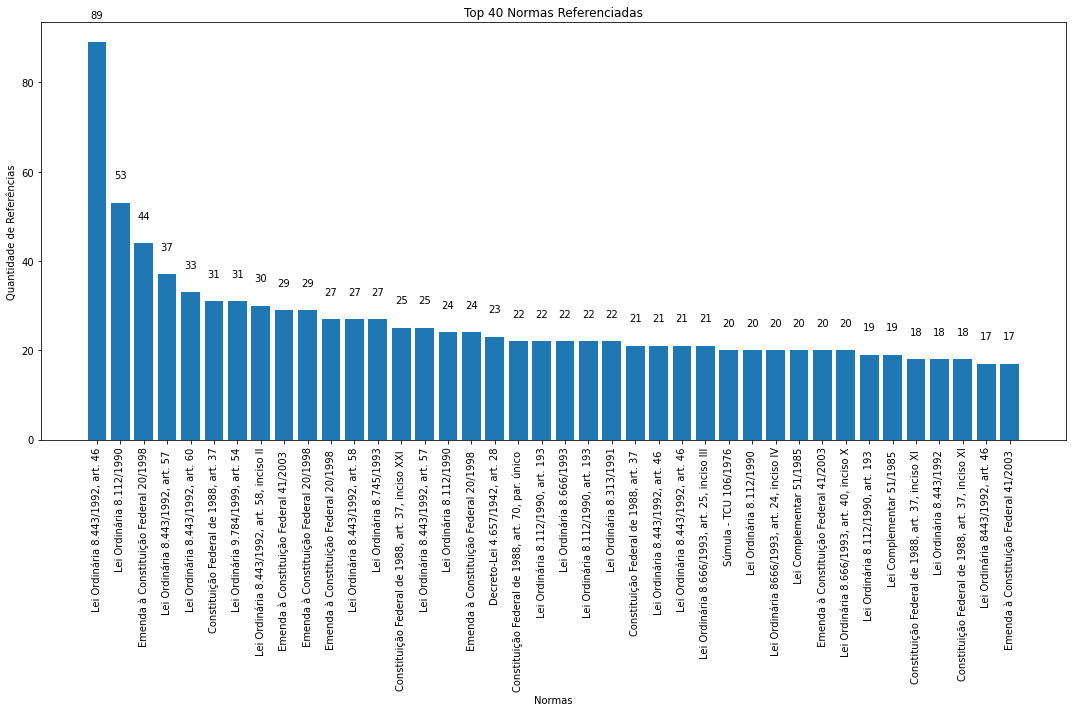

In [79]:
normas_referenciadas = df_enunciado['REFERENCE_LIST'].str.extractall(r'([^||]+)')[0]

# Calcular o total de ocorrências de cada norma referenciada
contagem_normas = Counter(normas_referenciadas)

# Obter as top 40 normas referenciadas mais frequentes
top_40_normas = contagem_normas.most_common(40)

# Extrair os nomes e as quantidades das top 40 normas
normas = [norma[0] for norma in top_40_normas]
quantidades = [norma[1] for norma in top_40_normas]

# Plotar o gráfico de barras
plt.figure(figsize=(15, 10))
plt.bar(normas, quantidades)
plt.title('Top 40 Normas Referenciadas')
plt.xlabel('Normas')
plt.ylabel('Quantidade de Referências')
plt.xticks(rotation=90)

# Adicionar rótulos com a quantidade de referências em cada barra
for i, v in enumerate(quantidades):
    plt.text(i, v + 5, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

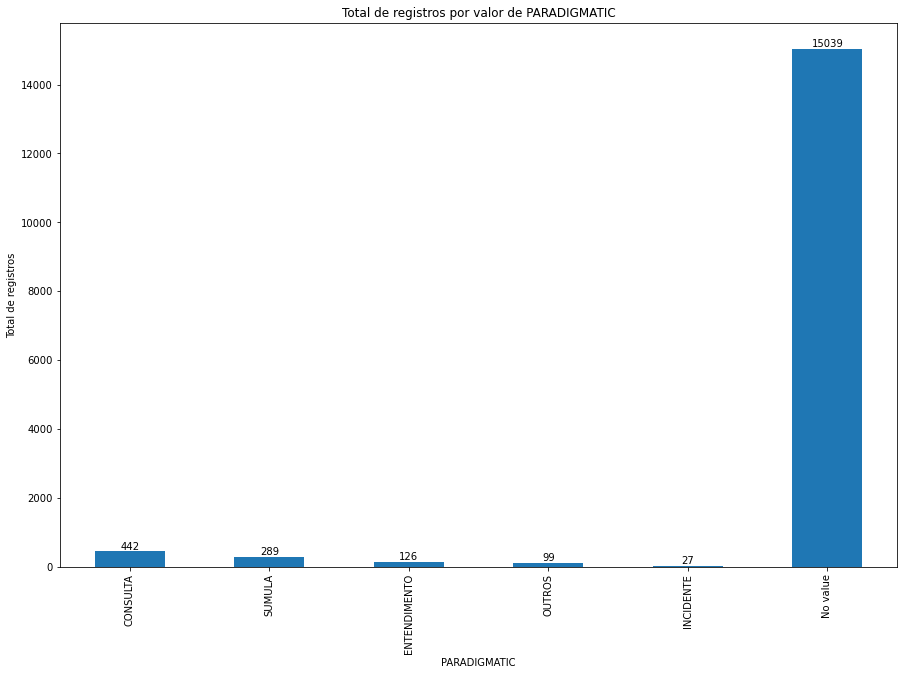

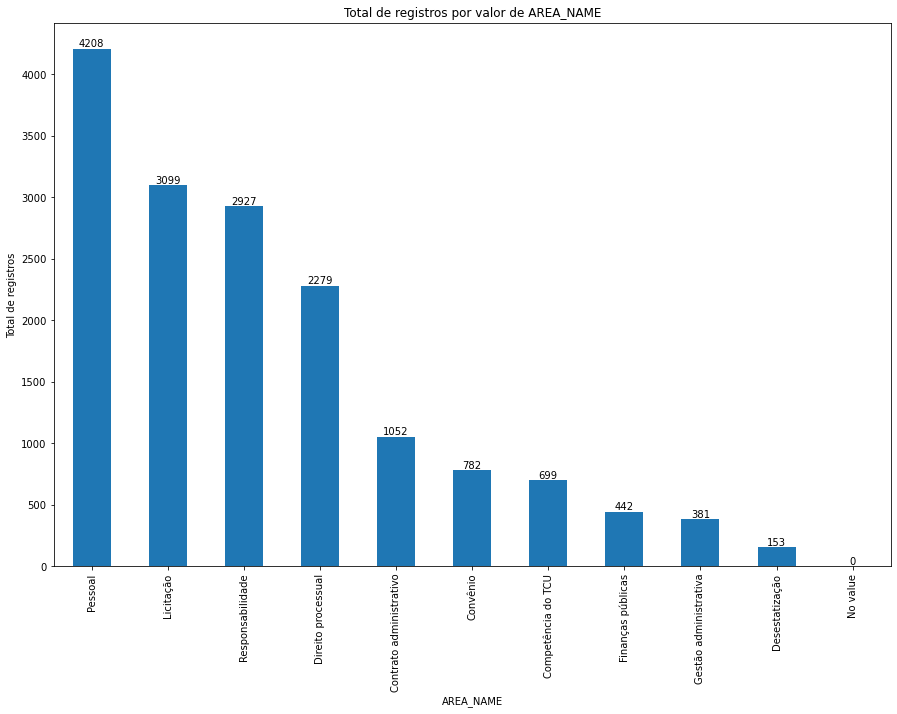

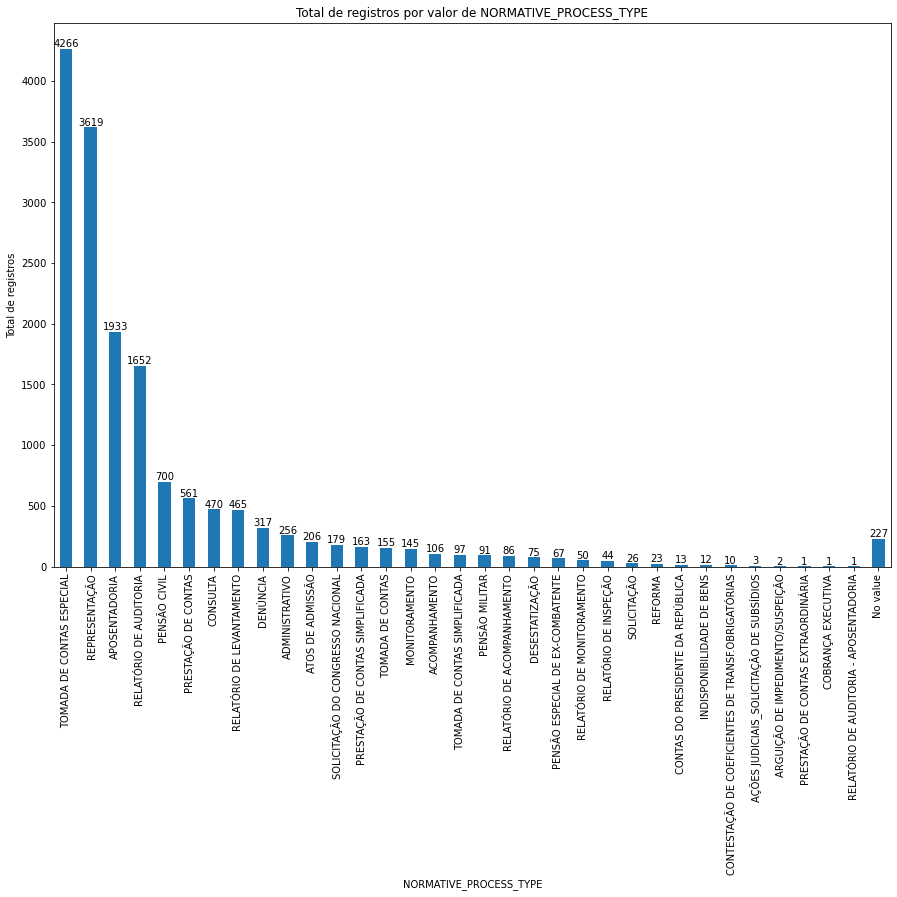

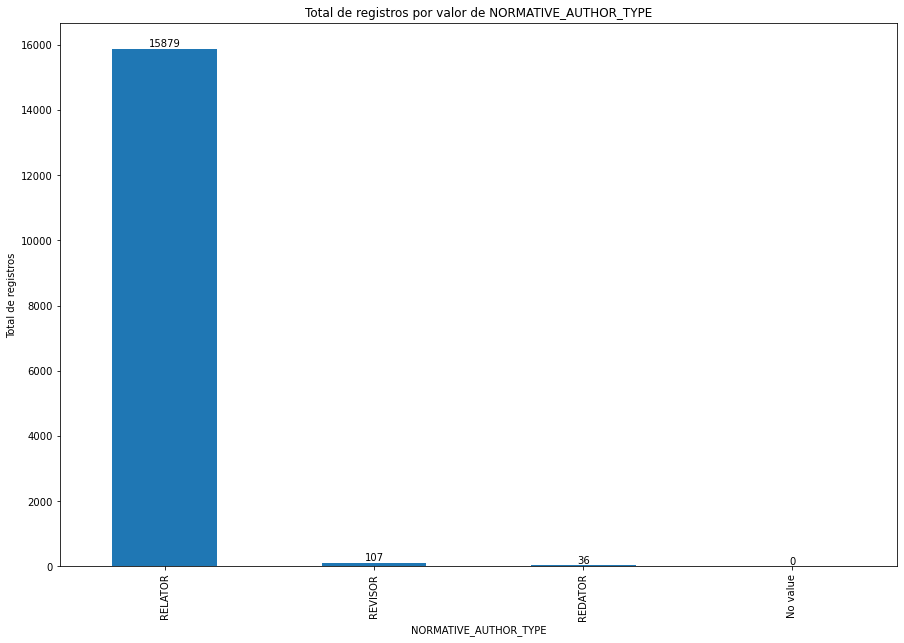

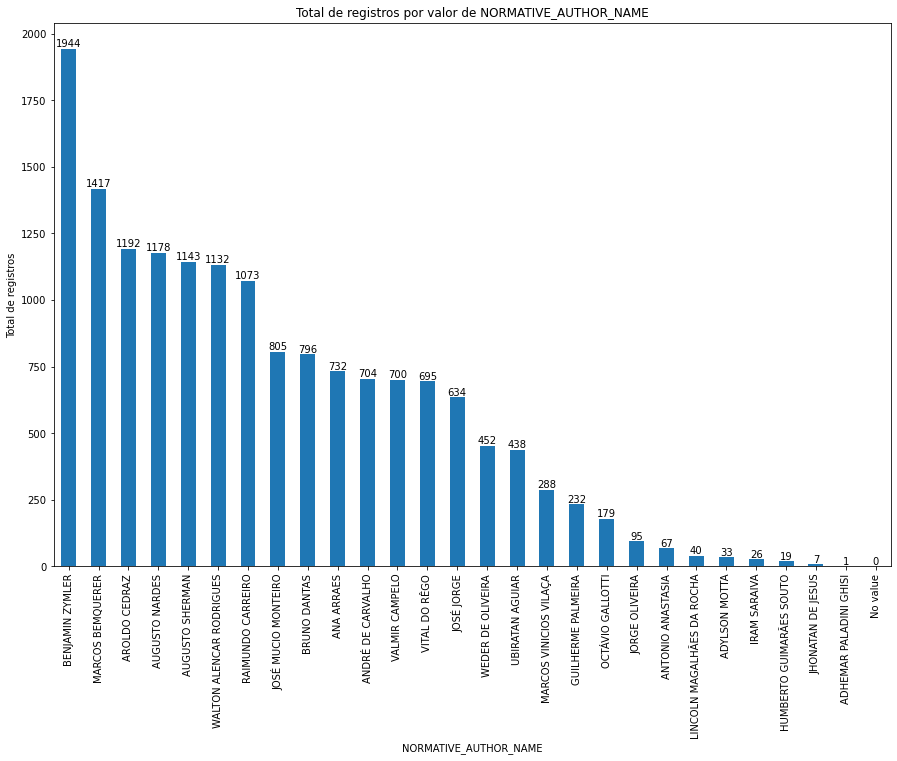

In [41]:
# Loop através das propriedades
for property_name in list_property:
    # Calcular o total de registros por valor da propriedade
    property_counts = df_enunciado[property_name].value_counts()

    # Obter o total de registros sem valor (sem registros)
    total_missing = df_enunciado[property_name].isna().sum()

    # Adicionar o total de registros sem valor no total de registros por valor
    property_counts['No value'] = total_missing

    # Plotar o gráfico de barras
    plt.figure(figsize=(15,10))
    property_counts.plot(kind='bar')
    plt.title(f'Total de registros por valor de {property_name}')
    plt.xlabel(property_name)
    plt.ylabel('Total de registros')

    # Adicionar rótulos com o total de registros em cada barra
    for i, v in enumerate(property_counts):
        plt.annotate(str(v), xy=(i, v), ha='center', va='bottom')

    plt.show()

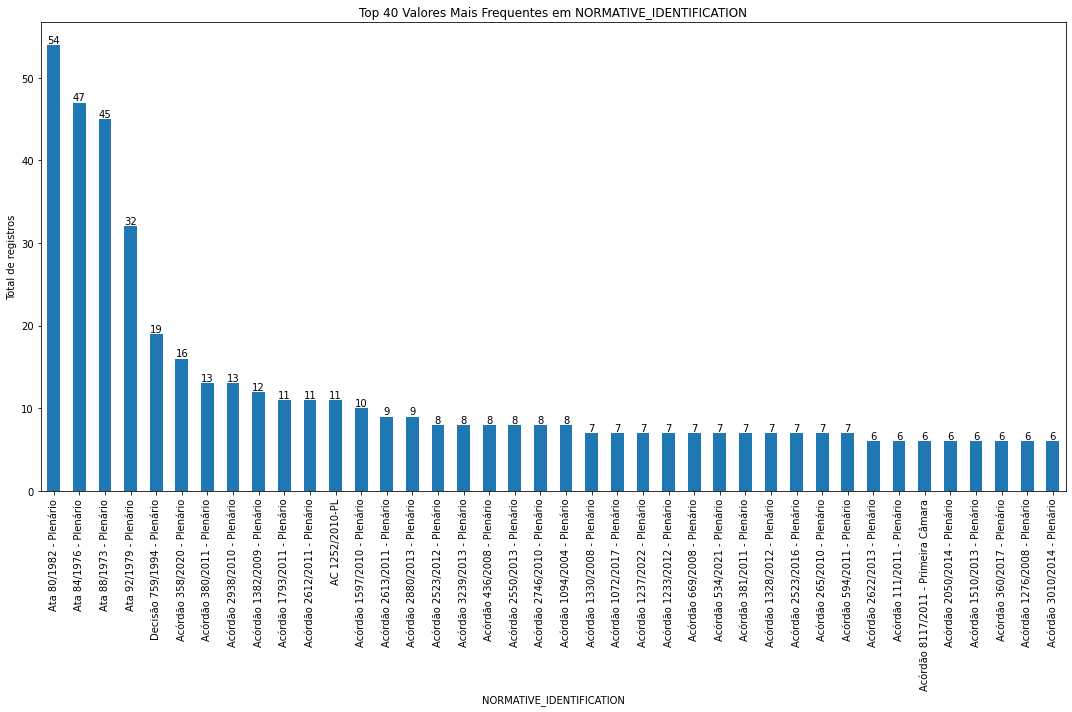

In [49]:
# Definir a coluna a ser explorada
column_name = 'NORMATIVE_IDENTIFICATION'

# Calcular o total de registros por valor na coluna
value_counts = df_enunciado[column_name].value_counts()

# Selecionar os top 40 valores mais frequentes
top_values = value_counts.head(40)

# Plotar o gráfico de barras
plt.figure(figsize=(15,10))
ax = top_values.plot(kind='bar')
plt.title(f'Top 40 Valores Mais Frequentes em {column_name}')
plt.xlabel(column_name)
plt.ylabel('Total de registros')
plt.xticks(rotation=90)
# Adicionar rótulos com o total de registros em cada barra
# Adicionar rótulos com a quantidade de registros em cada barra
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


plt.tight_layout()
plt.show()

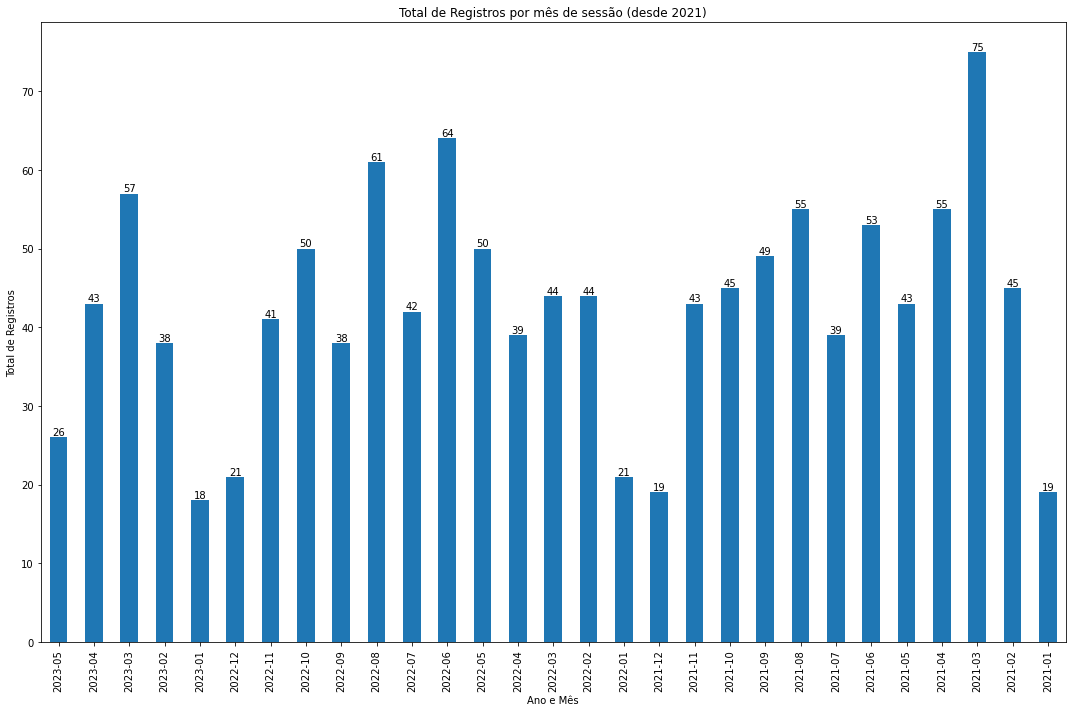

In [61]:
# Calcular o total de registros por ano e mês
df_enunciado['YearMonth'] = pd.to_datetime(df_enunciado[df_enunciado['NORMATIVE_DATE']>'2021']['NORMATIVE_DATE']).dt.to_period('M')
total_by_yearmonth = df_enunciado['YearMonth'].value_counts().sort_index(ascending=False)

# Plotar o gráfico de barras
plt.figure(figsize=(15, 10))
ax = total_by_yearmonth.plot(kind='bar')
plt.title('Total de Registros por mês de sessão (desde 2021)')
plt.xlabel('Ano e Mês')
plt.ylabel('Total de Registros')
plt.xticks(rotation=90)

# Adicionar rótulos com a quantidade de registros em cada barra
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

plt.tight_layout()
plt.show()

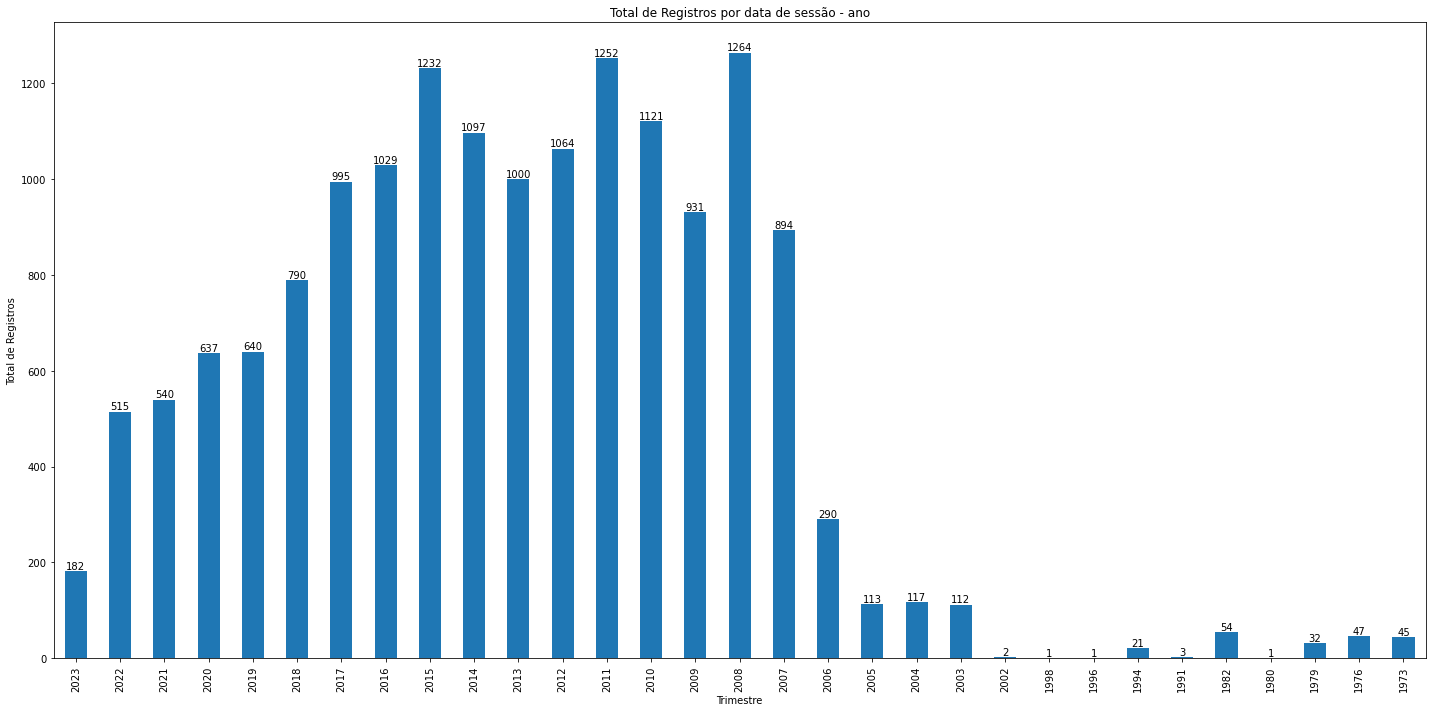

In [87]:

# Calcular o total de registros por trimestre
total_by_period = df_enunciado['NORMATIVE_DATE'].apply(lambda x: pd.Period(x, freq='Y')).value_counts().sort_index(ascending=False)

# Plotar o gráfico de barras
plt.figure(figsize=(20, 10))
ax = total_by_period.plot(kind='bar')
plt.title('Total de Registros por data de sessão - ano')
plt.xlabel('Trimestre')
plt.ylabel('Total de Registros')
plt.xticks(rotation=90)
# Adicionar rótulos com a quantidade de registros em cada barra
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

plt.tight_layout()
del total_by_period
plt.show()

Total por data da sessão (trimestre)

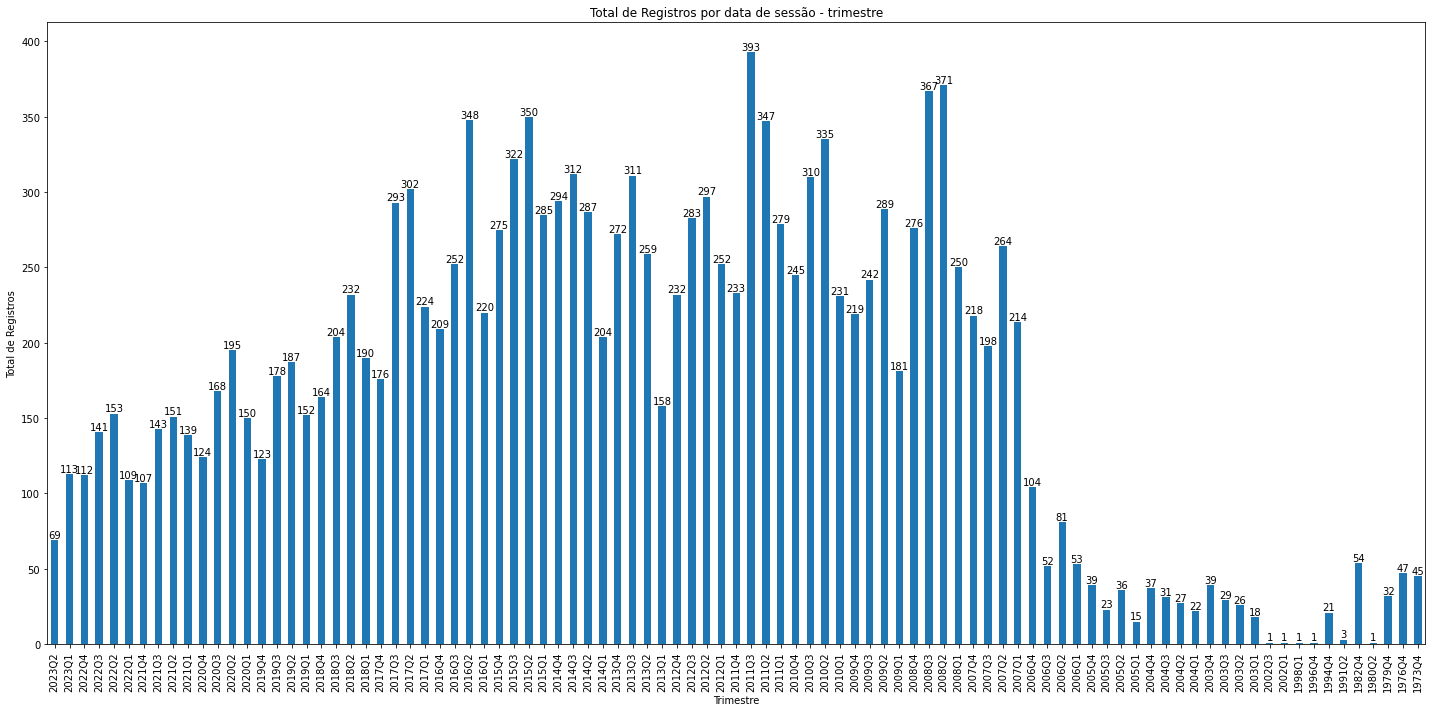

In [86]:

# Calcular o total de registros por trimestre
df_enunciado['YearQuarter'] = pd.to_datetime(df_enunciado['NORMATIVE_DATE']).dt.to_period('Q')
# total_by_period = df_enunciado['YearQuarter'].value_counts().sort_index(ascending=False)
# Calcular o total de registros por trimestre
total_by_period = df_enunciado['NORMATIVE_DATE'].apply(lambda x: pd.Period(x, freq='Q')).value_counts().sort_index(ascending=False)

# Plotar o gráfico de barras
plt.figure(figsize=(20, 10))
ax = total_by_period.plot(kind='bar')
plt.title('Total de Registros por data de sessão - trimestre')
plt.xlabel('Trimestre')
plt.ylabel('Total de Registros')
plt.xticks(rotation=90)
# Adicionar rótulos com a quantidade de registros em cada barra
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

plt.tight_layout()
del total_by_period
plt.show()

Tamanho dos enunciados - palavras, caracteres e tokens

In [88]:
df_enunciado['LEN_TEXT_CHAR'] = df_enunciado['TEXT'].apply(len)

In [90]:
df_enunciado['LEN_TEXT_CHAR_LOG'] = round(np.log(df_enunciado['TEXT'].apply(len))).astype(int)


In [133]:
df_enunciado['NUM_WORD'] = df_enunciado['TEXT'].apply(lambda x: len(x.split()))


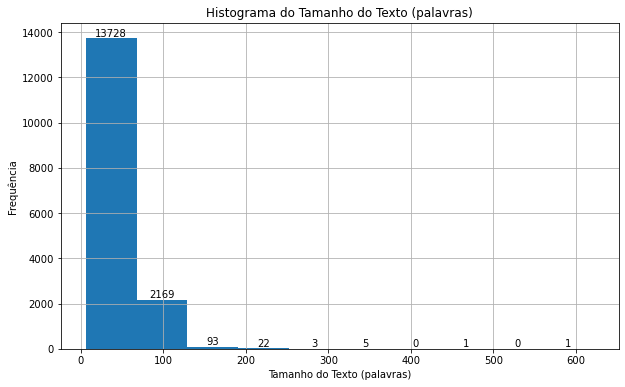

In [136]:

# Plotar o histograma
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(df_enunciado['NUM_WORD'], bins=10)
plt.title('Histograma do Tamanho do Texto (palavras)')
plt.xlabel('Tamanho do Texto (palavras)')
plt.ylabel('Frequência')
plt.grid(True)

# Adicionar rótulos com a quantidade de registros em cada barra
for i, patch in enumerate(patches):
    height = patch.get_height()
    plt.text(patch.get_x() + patch.get_width() / 2, height, int(height),
             ha='center', va='bottom')

plt.show()


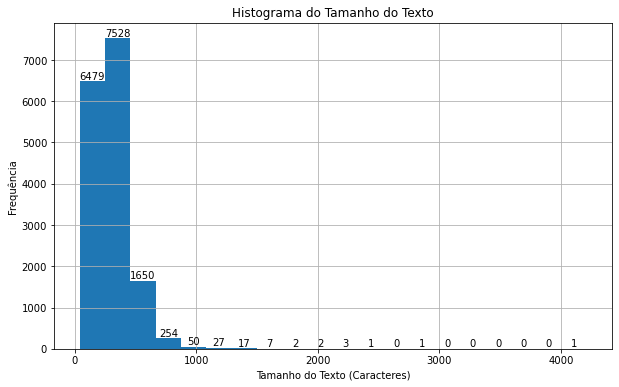

In [93]:

# Plotar o histograma
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(df_enunciado['LEN_TEXT_CHAR'], bins=20)
plt.title('Histograma do Tamanho do Texto (caracteres)')
plt.xlabel('Tamanho do Texto (Caracteres)')
plt.ylabel('Frequência')
plt.grid(True)

# Adicionar rótulos com a quantidade de registros em cada barra
for i, patch in enumerate(patches):
    height = patch.get_height()
    plt.text(patch.get_x() + patch.get_width() / 2, height, int(height),
             ha='center', va='bottom')

plt.show()


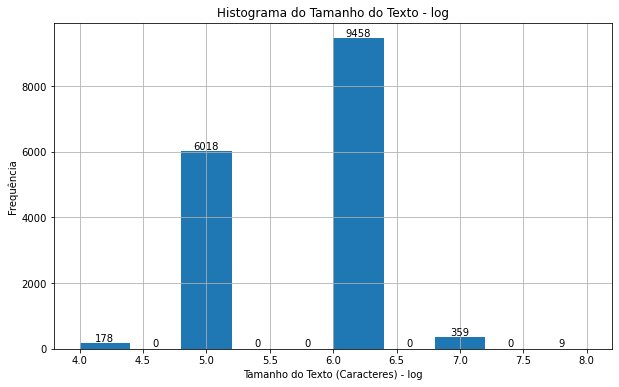

In [105]:

# Plotar o histograma
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(df_enunciado['LEN_TEXT_CHAR_LOG'], bins=10)
plt.title('Histograma do Tamanho do Texto - log')
plt.xlabel('Tamanho do Texto (Caracteres) - log')
plt.ylabel('Frequência')
plt.grid(True)

# Adicionar rótulos com a quantidade de registros em cada barra
for i, patch in enumerate(patches):
    height = patch.get_height()
    plt.text(patch.get_x() + patch.get_width() / 2, height, int(height),
             ha='center', va='bottom')

plt.show()


In [102]:
print(f"Total de enunciados com mais de 1000 letras: {df_enunciado[df_enunciado['LEN_TEXT_CHAR']>1000].shape[0]} {100 * df_enunciado[df_enunciado['LEN_TEXT_CHAR']>1000].shape[0]/df_enunciado.shape[0]:.4f}%")

Total de enunciados com mais de 1000 letras: 67 0.4182%


Verificação por tokens

In [106]:
from transformers import AutoTokenizer #, AutoModelForSequenceClassification

In [ ]:
texto = df_enunciado[df_enunciado['LEN_TEXT_CHAR']>1000].iloc[0]['TEXT']

In [ ]:
texto

'Nas transferências voluntárias de recursos da União destinados à realização de investimentos em estrutura física de sistema gerido por concessionária de serviços de saneamento, qualquer que seja a composição do seu capital, é obrigatório que essa entidade e o ente federativo beneficiado figurem como intervenientes na avença e assumam a obrigação: (i) de que os investimentos realizados com recursos federais não onerosos: não componham a base tarifária da concessionária, a título de depreciação, amortização e exaustão; não gerem direito a indenização ao término da concessão; sejam registrados pelo ente federativo titular do serviço público e pela concessionária, em item patrimonial específico; sejam excluídos do plano de investimentos da concessionária, com a correspondente compensação mediante substituição por investimentos da mesma monta ou dedução da base tarifária; (ii) de promover o reequilíbrio econômico-financeiro da concessão sempre que os investimentos realizados com recursos f

In [107]:
nome_modelo_ranking_pt = 'unicamp-dl/mMiniLM-L6-v2-pt-v2'
nome_caminho_modelo_pt = "/home/borela/fontes/relevar-busca/modelo/" + nome_modelo_ranking_pt
assert os.path.exists(nome_caminho_modelo_pt), f"Path para {nome_caminho_modelo_pt} não existe!"

In [115]:
tokenizador_pt_minilm = AutoTokenizer.from_pretrained(nome_caminho_modelo_pt)

In [116]:
features = tokenizador_pt_minilm.tokenize(
            texto,
            #padding=True,
            #truncation=True,
           )
print(features)

['▁Nas', '▁transferência', 's', '▁volunt', 'árias', '▁de', '▁recursos', '▁da', '▁União', '▁destinado', 's', '▁à', '▁realização', '▁de', '▁investimentos', '▁em', '▁estrutura', '▁física', '▁de', '▁sistema', '▁geri', 'do', '▁por', '▁concession', 'ária', '▁de', '▁serviços', '▁de', '▁sa', 'ne', 'amento', ',', '▁qualquer', '▁que', '▁seja', '▁a', '▁com', 'posição', '▁do', '▁seu', '▁capital', ',', '▁é', '▁obriga', 'tório', '▁que', '▁essa', '▁entidade', '▁e', '▁o', '▁en', 'te', '▁federa', 'tivo', '▁beneficia', 'do', '▁figure', 'm', '▁como', '▁interven', 'ientes', '▁na', '▁av', 'en', 'ça', '▁e', '▁a', 'ssum', 'am', '▁a', '▁obriga', 'ção', ':', '▁(', 'i', ')', '▁de', '▁que', '▁os', '▁investimentos', '▁realizados', '▁com', '▁recursos', '▁federa', 'is', '▁não', '▁on', 'er', 'osos', ':', '▁não', '▁comp', 'on', 'ham', '▁a', '▁base', '▁tarif', 'ária', '▁da', '▁concession', 'ária', ',', '▁a', '▁título', '▁de', '▁de', 'preci', 'ação', ',', '▁amortiz', 'ação', '▁e', '▁ex', 'a', 'ust', 'ão', ';', '▁não', 

In [126]:
def retorna_num_tokens(parm_texto:str, parm_tokenizador:AutoTokenizer):
    return len(parm_tokenizador.tokenize(parm_texto))
retorna_num_tokens(texto, tokenizador_pt_minilm)

238

In [118]:
nome_modelo_monot5_3b = 'unicamp-dl/mt5-3B-mmarco-en-pt'
# "A mono-ptT5 reranker model (850 mb) pretrained in the BrWac corpus, finetuned for 100k steps on Portuguese translated version of MS MARCO passage dataset. The portuguese dataset was translated using Google Translate.")

nome_caminho_modelo_3b = "/home/borela/fontes/relevar-busca/modelo/" + nome_modelo_monot5_3b
assert os.path.exists(nome_caminho_modelo_3b), f"Path para {nome_caminho_modelo_3b} não existe!"

In [119]:
tokenizador_pt_monot5_3b = AutoTokenizer.from_pretrained(nome_caminho_modelo_3b)

/home/borela/miniconda3/envs/relevar-busca/lib/python3.7/site-packages/transformers/convert_slow_tokenizer.py:447: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"


In [120]:
features_3b = tokenizador_pt_monot5_3b.tokenize(
            texto,
            #padding=True,
            #truncation=True,
           )
print(features_3b)

['▁Nas', '▁transfer', 'ências', '▁volunt', 'árias', '▁de', '▁', 'recursos', '▁da', '▁Uni', 'ão', '▁destina', 'dos', '▁', 'à', '▁realiza', 'ção', '▁de', '▁', 'investimento', 's', '▁em', '▁', 'estrutura', '▁', 'físic', 'a', '▁de', '▁sistema', '▁geri', 'do', '▁por', '▁', 'concession', 'ária', '▁de', '▁', 's', 'erviços', '▁de', '▁sane', 'amento', ',', '▁qual', 'quer', '▁que', '▁seja', '▁', 'a', '▁', 'com', 'posição', '▁do', '▁seu', '▁capital', ',', '▁', 'é', '▁obriga', 'tório', '▁que', '▁essa', '▁', 'entidad', 'e', '▁', 'e', '▁', 'o', '▁', 'ente', '▁federa', 'tivo', '▁beneficia', 'do', '▁figure', 'm', '▁como', '▁interven', 'ientes', '▁na', '▁av', 'ença', '▁', 'e', '▁assum', 'am', '▁', 'a', '▁obriga', 'ção', ':', '▁(', 'i', ')', '▁de', '▁que', '▁', 'os', '▁', 'investimento', 's', '▁realiza', 'dos', '▁', 'com', '▁', 'recursos', '▁federa', 'is', '▁não', '▁one', 'rosos', ':', '▁não', '▁compo', 'n', 'ham', '▁', 'a', '▁base', '▁tarif', 'ária', '▁da', '▁', 'concession', 'ária', ',', '▁', 'a', '▁'

In [161]:
print(features)

['▁Nas', '▁transferência', 's', '▁volunt', 'árias', '▁de', '▁recursos', '▁da', '▁União', '▁destinado', 's', '▁à', '▁realização', '▁de', '▁investimentos', '▁em', '▁estrutura', '▁física', '▁de', '▁sistema', '▁geri', 'do', '▁por', '▁concession', 'ária', '▁de', '▁serviços', '▁de', '▁sa', 'ne', 'amento', ',', '▁qualquer', '▁que', '▁seja', '▁a', '▁com', 'posição', '▁do', '▁seu', '▁capital', ',', '▁é', '▁obriga', 'tório', '▁que', '▁essa', '▁entidade', '▁e', '▁o', '▁en', 'te', '▁federa', 'tivo', '▁beneficia', 'do', '▁figure', 'm', '▁como', '▁interven', 'ientes', '▁na', '▁av', 'en', 'ça', '▁e', '▁a', 'ssum', 'am', '▁a', '▁obriga', 'ção', ':', '▁(', 'i', ')', '▁de', '▁que', '▁os', '▁investimentos', '▁realizados', '▁com', '▁recursos', '▁federa', 'is', '▁não', '▁on', 'er', 'osos', ':', '▁não', '▁comp', 'on', 'ham', '▁a', '▁base', '▁tarif', 'ária', '▁da', '▁concession', 'ária', ',', '▁a', '▁título', '▁de', '▁de', 'preci', 'ação', ',', '▁amortiz', 'ação', '▁e', '▁ex', 'a', 'ust', 'ão', ';', '▁não', 

In [124]:
print(f"Total de tokens minilm: {len(features)}, monot5_3b: {len(features_3b)}")

Total de tokens minilm: 238, monot5_3b: 311


In [127]:
df_enunciado['NUM_TOKENS_MONOT5_3B'] = df_enunciado['TEXT'].apply(retorna_num_tokens, parm_tokenizador=tokenizador_pt_monot5_3b)

In [128]:
df_enunciado['NUM_TOKENS_MINILM'] = df_enunciado['TEXT'].apply(retorna_num_tokens, parm_tokenizador=tokenizador_pt_minilm)

In [129]:
df_enunciado.head()

,ID,TEXT,REFERENCE_LIST,PARADIGMATIC,AREA_NAME,AREA_ID_DESCRIPTOR,NORMATIVE_PROCESS_TYPE,NORMATIVE_IDENTIFICATION,NORMATIVE_DATE,NORMATIVE_AUTHOR_TYPE,NORMATIVE_AUTHOR_NAME,YearQuarter,LEN_TEXT_CHAR,LEN_TEXT_CHAR_LOG,NUM_TOKENS_MONOT5_3B,NUM_TOKENS_MINILM
0,34899,"A transferência de documentos da entidade para local impróprio ao armazenamento, causando a perd...","Lei Ordinária 8.443/1992, art. 58, inciso II",NaN,Responsabilidade,775,REPRESENTAÇÃO,Acórdão 2669/2012 - Plenário,2012-10-03,RELATOR,JOSÉ JORGE,2012Q4,235,5,69,53
1,30271,"A contratação de médicos e profissionais da área de saúde, como colaboradores eventuais, com pag...",NaN,NaN,Pessoal,1131,REPRESENTAÇÃO,Acórdão 2669/2012 - Plenário,2012-10-03,RELATOR,JOSÉ JORGE,2012Q4,141,5,41,30
2,26574,"Para que seja conhecido o recurso de revisão, não basta apenas que se apresente documento ainda ...",NaN,NaN,Direito processual,5288,TOMADA DE CONTAS,Acórdão 514/2013 - Plenário,2013-03-13,RELATOR,ANA ARRAES,2013Q1,347,6,102,78
3,17902,"A contratação de serviços comuns de engenharia que possam ser objetivamente definidos em edital,...",NaN,NaN,Licitação,932,RELATÓRIO DE LEVANTAMENTO,Acórdão 3144/2012 - Plenário,2012-11-21,RELATOR,ANA ARRAES,2012Q4,180,5,54,45
4,26089,"A Fundação Banco do Brasil, por receber recursos da União, deve observar, quando do repasse de r...",NaN,NaN,Competência do TCU,5095,TOMADA DE CONTAS ESPECIAL,Acórdão 2071/2013 - Plenário,2013-08-07,RELATOR,JOSÉ JORGE,2013Q3,166,5,49,34


In [138]:
df_enunciado[['LEN_TEXT_CHAR','NUM_WORD','NUM_TOKENS_MINILM', 'NUM_TOKENS_MONOT5_3B']].describe().round(0)

,LEN_TEXT_CHAR,NUM_WORD,NUM_TOKENS_MINILM,NUM_TOKENS_MONOT5_3B
count,16022.0,16022.0,16022.0,16022.0
mean,307.0,47.0,70.0,88.0
std,157.0,24.0,38.0,47.0
min,41.0,6.0,10.0,13.0
25%,205.0,31.0,46.0,58.0
50%,279.0,43.0,63.0,80.0
75%,375.0,57.0,86.0,108.0
max,4212.0,621.0,945.0,1219.0


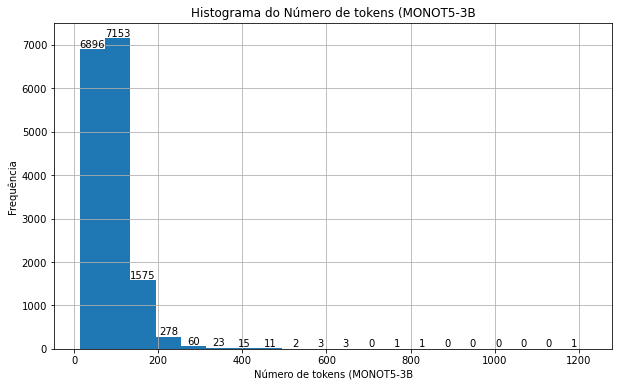

In [139]:
# Plotar o histograma
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(df_enunciado['NUM_TOKENS_MONOT5_3B'], bins=20)
plt.title('Histograma do Número de tokens (MONOT5-3B')
plt.xlabel('Número de tokens (MONOT5-3B')
plt.ylabel('Frequência')
plt.grid(True)

# Adicionar rótulos com a quantidade de registros em cada barra
for i, patch in enumerate(patches):
    height = patch.get_height()
    plt.text(patch.get_x() + patch.get_width() / 2, height, int(height),
             ha='center', va='bottom')

plt.show()


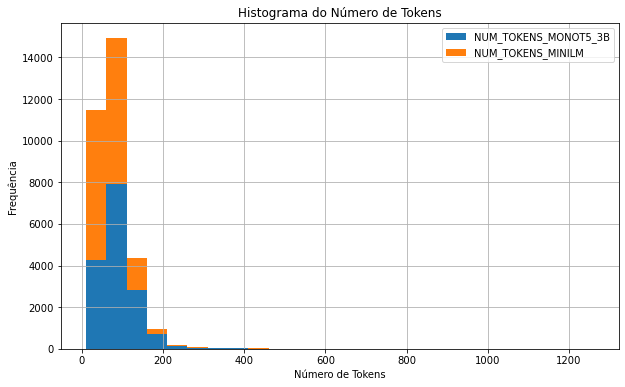

In [145]:
# Definir os limites dos intervalos
bin_width = 50
min_value = min(df_enunciado['NUM_TOKENS_MONOT5_3B'].min(), df_enunciado['NUM_TOKENS_MINILM'].min())
max_value = max(df_enunciado['NUM_TOKENS_MONOT5_3B'].max(), df_enunciado['NUM_TOKENS_MINILM'].max())
bins = np.arange(min_value, max_value + bin_width, bin_width)

# Plotar o histograma empilhado
plt.figure(figsize=(10, 6))
plt.hist([df_enunciado['NUM_TOKENS_MONOT5_3B'], df_enunciado['NUM_TOKENS_MINILM']], bins=bins, histtype='barstacked',
         label=['NUM_TOKENS_MONOT5_3B', 'NUM_TOKENS_MINILM'])
plt.title('Histograma do Número de Tokens')
plt.xlabel('Número de Tokens')
plt.ylabel('Frequência')
plt.grid(True)
plt.legend()

plt.show()

# Data exploration of indexing (qrel)

In [407]:
df_index = pd.read_csv(PATH_QREL)

In [408]:
df_index.shape

(94653, 3)

In [409]:
df_index.head()

,ID_QUERY,ID_DOCTO,TYPE
0,158,15147,INDEXACAO_EXTRA
1,37,15147,INDEXACAO_EXTRA
2,178,15147,INDEXACAO_EXTRA
3,14564,15147,INDEXACAO_EXTRA
4,9219,15147,INDEXACAO_EXTRA


Agregar nome do termo

In [410]:
df_doc = pd.read_csv(PATH_DOC)

In [411]:
df_doc.head()

,TEXT,ID,NAME,DATE_REFERENCE,CLASS,HAS_SCOPE_NOTE,HAS_DEFINITION,HAS_SYNONYM,HAS_EXAMPLE,HAS_ENGLISH_TRANSLATION,HAS_SPECIALIZATION,HAS_RELATED_TERM,HAS_SPANISH_TRANSLATION,HAS_GENERALIZATION,TEXT_DEFINITION,TEXT_SYNONYM,TEXT_RELATED_TERM,TEXT_SCOPE_NOTE,TEXT_EXAMPLE,TEXT_ENGLISH_TRANSLATION,TEXT_SPANISH_TRANSLATION,TEXT_SPECIALIZATION,TEXT_GENERALIZATION,COUNT_INDEX_AREA,COUNT_INDEX_THEME,COUNT_INDEX_SUBTHEME,COUNT_INDEX_EXTRA,COUNT_INDEX_TOTAL
0,"O termo é ""Abandono de cargo"".\nAbandono de cargo tem definição: ""Configura abandono de cargo a ausência intencional do servidor ao serviço por mais de trinta dias consecutivos."".\nAbandono de cargo tem nota de escopo: ""Artigo 323 Código Penal: ""Abandonar cargo público, fora dos casos permitidos em lei."""".\nAbandono de cargo tem sinônimo: ""Abandono de função"" e ""Abandono do cargo"".\nAbandono de cargo tem termo relacionado: ""Abandono de emprego"", ""Deserção"", ""Falta grave"", ""Função pública"", ""...",1,Abandono de cargo,20230605,Termo,1,1,1,0,1,0,1,1,0,Configura abandono de cargo a ausência intencional do servidor ao serviço por mais de trinta dias consecutivos.,Abandono de função e Abandono do cargo.,"Abandono de emprego, Deserção, Falta grave, Função pública, Demissão de servidor, Inassiduidade habitual, Cargo público, Processo administrativo disciplinar e Pena disciplinar.",Artigo 323 Código Penal,NaN,Abandonment of office.,Abandono de puesto.,NaN,NaN,0,1,0,0,1
1,"O termo é ""Abastecimento de tropas e meios"".\nAbastecimento de tropas e meios é uma especialização de: ""Abastecimento"".\nAbastecimento de tropas e meios tem tradução em espanhol: ""Abastecimiento de tropas y medios"" e ""Suministro de tropas y médios"".\nAbastecimento de tropas e meios tem tradução em inglês: ""Supply of troops and means"".",2,Abastecimento de tropas e meios,20230605,Termo,0,0,0,0,1,0,0,1,1,NaN,NaN,NaN,NaN,NaN,Supply of troops and means.,Abastecimiento de tropas y medios e Suministro de tropas y médios.,Abastecimento.,NaN,0,0,0,1,1
2,"O termo é ""Tropa"".\nTropa tem definição: ""Termo coletivo que designa o pessoal de uma organização militar."".\nTropa tem termo relacionado: ""Organização militar"" e ""Missão"".\nTropa tem tradução em espanhol: ""Tropa"".\nTropa tem tradução em inglês: ""Troop"".",3,Tropa,20230605,Termo,0,1,0,0,1,0,1,1,0,Termo coletivo que designa o pessoal de uma organização militar.,NaN,Organização militar e Missão.,NaN,NaN,Troop.,Tropa.,NaN,NaN,0,0,0,0,0
3,"O termo é ""Abono de faltas"".\nAbono de faltas tem definição: ""É a relevação da falta, de forma que o servidor não sofra qualquer desconto pelo dia não trabalhado. São 6 (seis), no máximo, as faltas abonadas ao ano para os servidores autárquicos (docentes e não-docentes) e 6 (seis) por período aquisitivo para os celetistas, não podendo ser abonada mais que uma falta por mês. O abono não é um direito do servidor e sim uma concessão e a aceitação ou não do abono fica a critério da chefia imedia...",4,Abono de faltas,20230605,Termo,1,1,1,0,0,0,1,0,0,"É a relevação da falta, de forma que o servidor não sofra qualquer desconto pelo dia não trabalhado. São 6 (seis), no máximo, as faltas abonadas ao ano para os servidores autárquicos (docentes e não-docentes) e 6 (seis) por período aquisitivo para os celetistas, não podendo ser abonada mais que uma falta por mês. O abono não é um direito do servidor e sim uma concessão e a aceitação ou não do abono fica a critério da chefia imediata, de acordo com os motivos alegados pelo servidor.","Faltas, Abono das faltas e Abono de ausências.",Inassiduidade habitual e Afastamento de pessoal.,Usado para servidores regidos pela CLT (art. 473).,NaN,NaN,NaN,NaN,NaN,0,0,0,1,1
4,"O termo é ""Abono de permanência em serviço"".\nAbono de permanência em serviço tem definição: ""O abono de permanência será pago ao servidor que tiver preenchido as exigências para aposentadoria voluntária e que opte por permanecer em atividade, até que complete 70 anos de idade, equivalente ao valor da cont

In [412]:
assert df_index.merge(df_doc[['ID', 'NAME']], how='inner', left_on='ID_DOCTO', right_on='ID').shape[0] == df_index.shape[0], f"It is missing document in DOC file."

In [413]:
df_index = df_index.merge(df_doc[['ID', 'NAME', 'CLASS']], how='inner', left_on='ID_DOCTO', right_on='ID').drop('ID', axis=1)

In [415]:
df_index.head()

,ID_QUERY,ID_DOCTO,TYPE,NAME,CLASS
0,158,15147,INDEXACAO_EXTRA,Referência,Termo
1,37,15147,INDEXACAO_EXTRA,Referência,Termo
2,178,15147,INDEXACAO_EXTRA,Referência,Termo
3,14564,15147,INDEXACAO_EXTRA,Referência,Termo
4,9219,15147,INDEXACAO_EXTRA,Referência,Termo


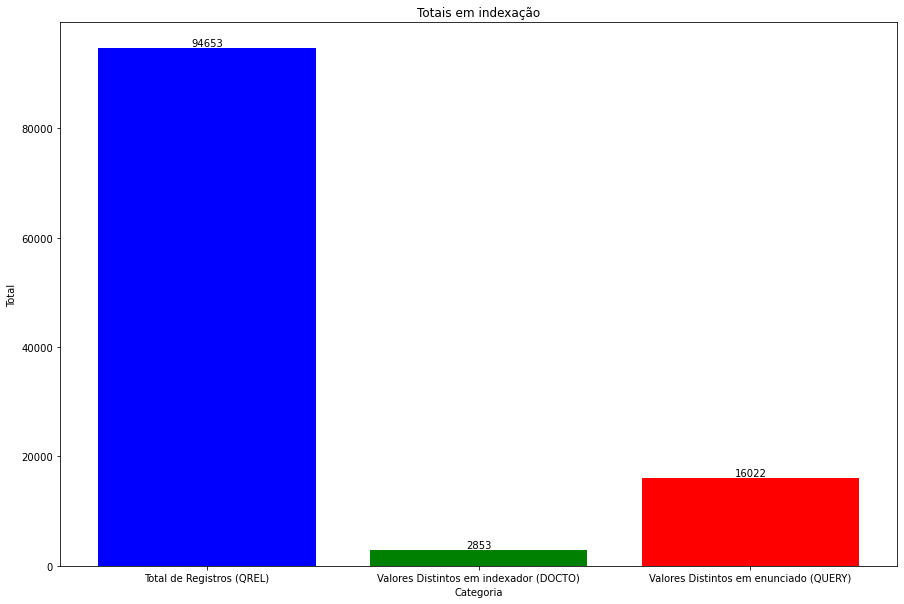

In [416]:
# Calcular os valores
total_registros = len(df_index)
valores_distintos_docto = df_index['ID_DOCTO'].nunique()
valores_distintos_query = df_index['ID_QUERY'].nunique()

# Criar os rótulos das barras
labels = ['Total de Registros (QREL)', 'Valores Distintos em indexador (DOCTO)', 'Valores Distintos em enunciado (QUERY)']

# Criar os valores das barras
valores = [total_registros, valores_distintos_docto, valores_distintos_query]

# Definir as cores das barras
cores = ['blue', 'green', 'red']

# Plotar o gráfico de barras
plt.figure(figsize=(15, 10))
plt.bar(labels, valores, color=cores)
plt.title('Totais em indexação')
plt.xlabel('Categoria')
plt.ylabel('Total')

# Adicionar os valores sobre as barras
for i, valor in enumerate(valores):
    plt.text(i, valor, str(valor), ha='center', va='bottom')

plt.show()


In [417]:
list_property = ['TYPE','CLASS']

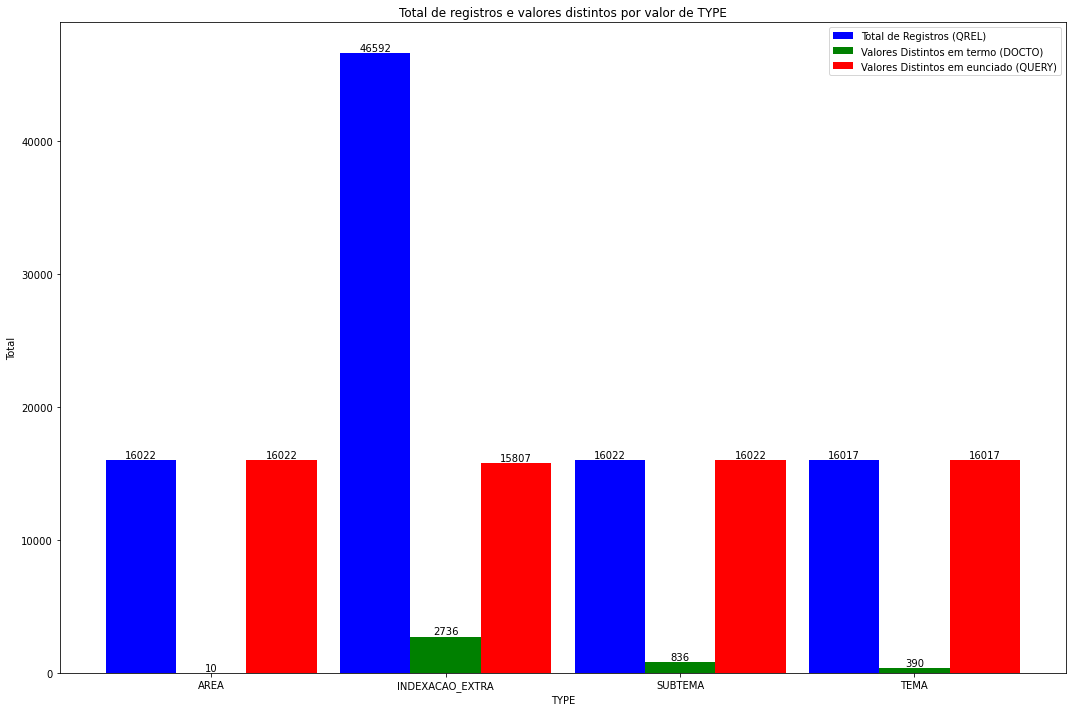

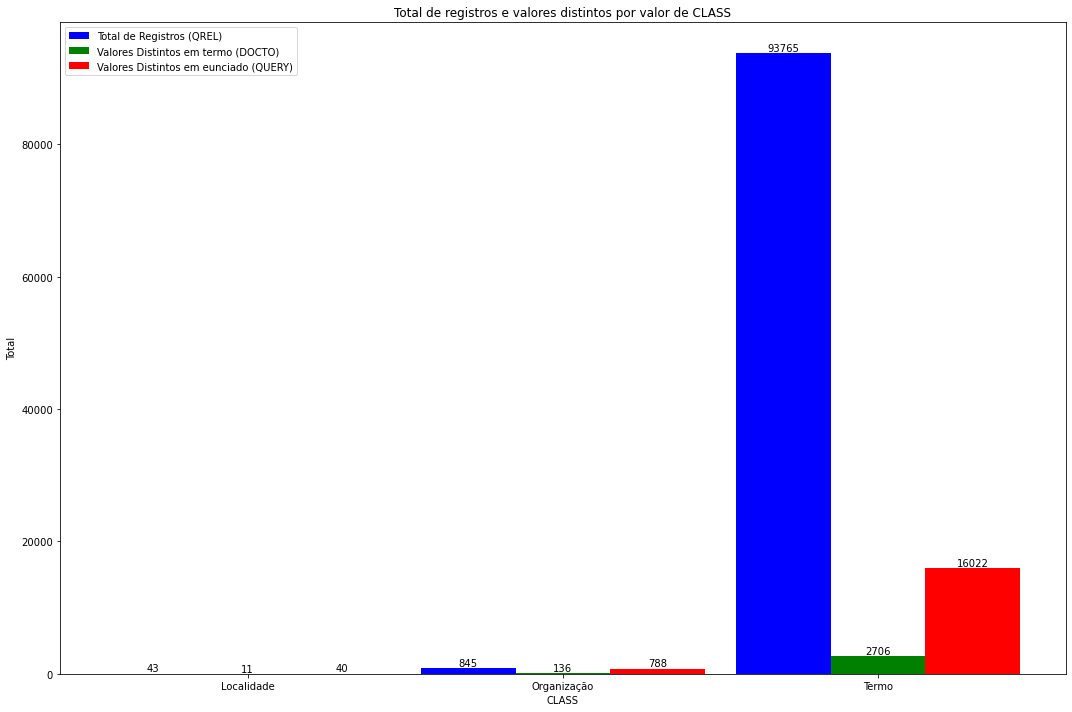

In [418]:
colors = ['blue', 'green', 'red']

for property_name in list_property:
    # Agrupar o DataFrame por valor da propriedade
    grouped_data = df_index.groupby(property_name)

    # Calcular o total de registros, valores distintos em 'ID_DOCTO' e valores distintos em 'ID_QUERY' para cada valor da propriedade
    total_counts = grouped_data.size()
    distinct_counts_docto = grouped_data['ID_DOCTO'].nunique()
    distinct_counts_query = grouped_data['ID_QUERY'].nunique()

    # Obter os rótulos únicos
    labels = total_counts.index

    # Definir a largura das barras
    bar_width = 0.3

    # Calcular a posição das barras para cada label distinto
    positions = np.arange(len(labels))

    # Plotar o gráfico de barras
    plt.figure(figsize=(15, 10))

    # Plotar a primeira barra
    plt.bar(positions - bar_width, total_counts, width=bar_width, color=colors[0], label='Total de Registros (QREL)')

    # Plotar a segunda barra
    plt.bar(positions, distinct_counts_docto, width=bar_width, color=colors[1], label='Valores Distintos em termo (DOCTO)')

    # Plotar a terceira barra
    plt.bar(positions + bar_width, distinct_counts_query, width=bar_width, color=colors[2], label='Valores Distintos em eunciado (QUERY)')

    plt.title(f'Total de registros e valores distintos por valor de {property_name}')
    plt.xlabel(property_name)
    plt.ylabel('Total')
    plt.legend()

    # Adicionar rótulos com os valores em cada barra
    for i, label in enumerate(labels):
        plt.text(i-0.3, total_counts[i], str(total_counts[i]), ha='center', va='bottom')
        plt.text(i, distinct_counts_docto[i], str(distinct_counts_docto[i]), ha='center', va='bottom')
        plt.text(i+0.3, distinct_counts_query[i], str(distinct_counts_query[i]), ha='center', va='bottom')

    plt.xticks(ticks=positions, labels=labels)
    plt.tight_layout()
    plt.show()


Ver indexações por termo

Mais usados

In [419]:
# Criar o DataFrame df_index_docto
df_index_docto = df_index.groupby(['ID_DOCTO','NAME'])['TYPE'].value_counts().unstack(fill_value=0)


In [420]:
# Resetar o índice
df_index_docto = df_index_docto.reset_index()

# Calcular a soma das colunas de TYPE
df_index_docto['TOTAL'] = df_index_docto.drop(['ID_DOCTO','NAME'],axis=1).sum(axis=1)

In [421]:
df_index_docto.shape

(2853, 7)

In [422]:
df_index_docto.head()

TYPE,ID_DOCTO,NAME,AREA,INDEXACAO_EXTRA,SUBTEMA,TEMA,TOTAL
0,1,Abandono de cargo,0,0,0,1,1
1,2,Abastecimento de tropas e meios,0,1,0,0,1
2,4,Abono de faltas,0,1,0,0,1
3,5,Abono de permanência em serviço,0,4,0,7,11
4,7,Absolvição,0,2,0,0,2


In [423]:
df_sorted = df_index_docto.sort_values(by='TOTAL', ascending=False).iloc[:50]

In [424]:
df_sorted.head()

TYPE,ID_DOCTO,NAME,AREA,INDEXACAO_EXTRA,SUBTEMA,TEMA,TOTAL
473,1131,Pessoal,4208,26,0,60,4294
397,932,Licitação,3099,167,3,285,3554
343,775,Responsabilidade,2927,48,0,0,2975
1429,5288,Direito processual,2279,1,0,0,2280
176,342,Convênio,782,153,1,753,1689


In [425]:
list_property = ['AREA','TEMA', 'SUBTEMA','INDEXACAO_EXTRA','TOTAL']

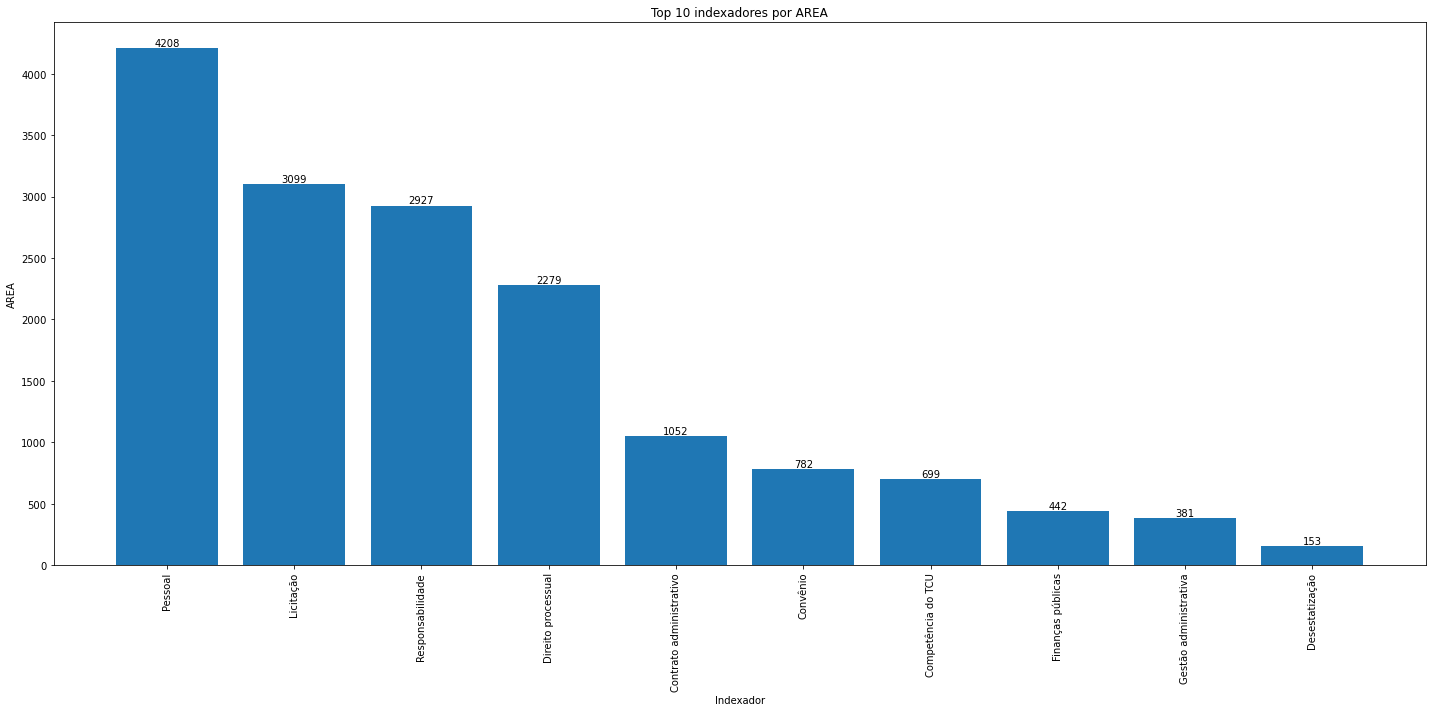

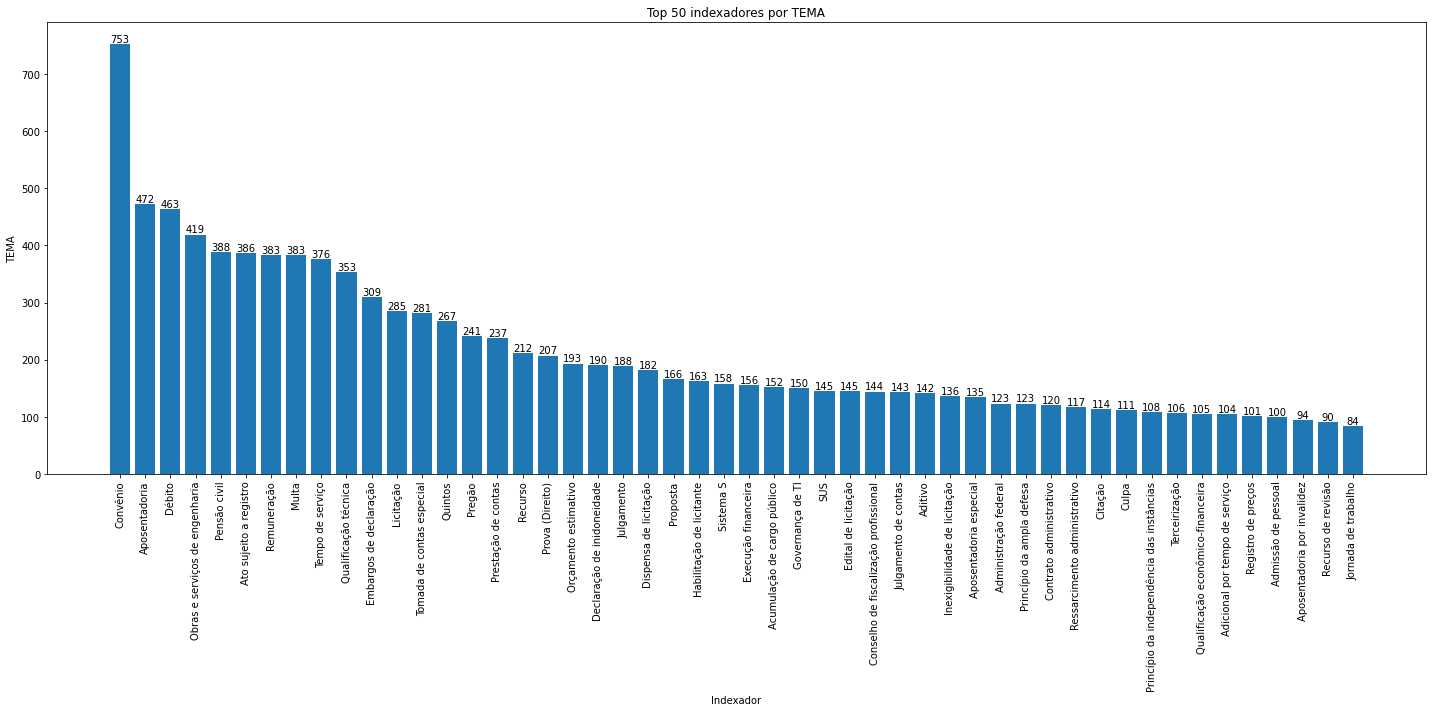

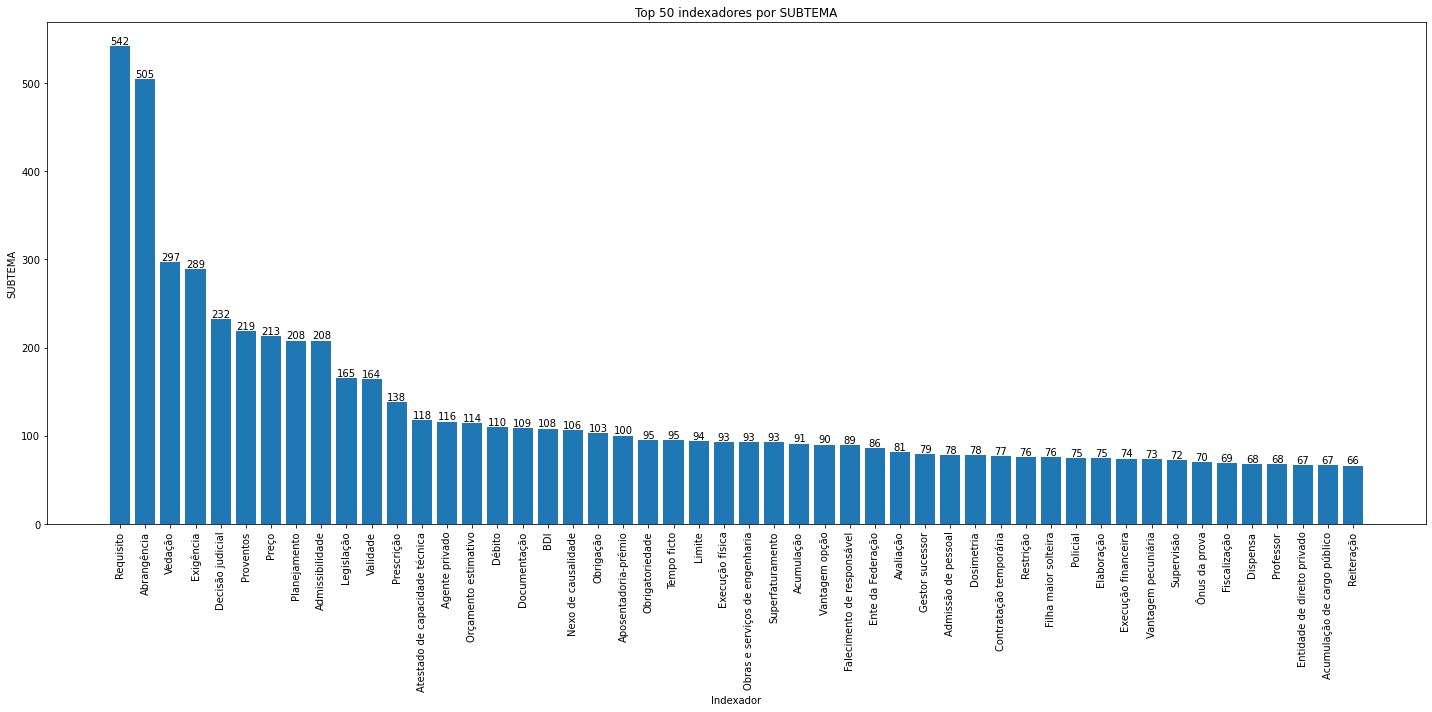

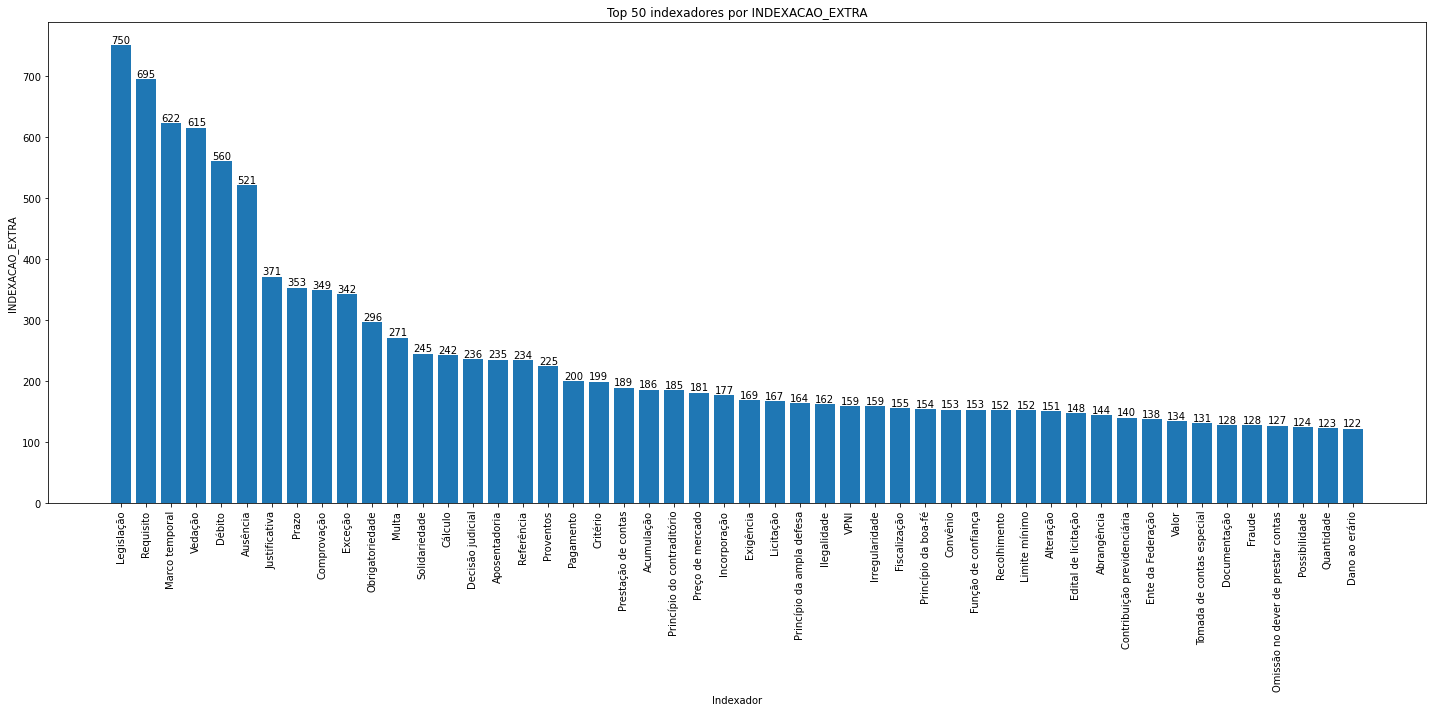

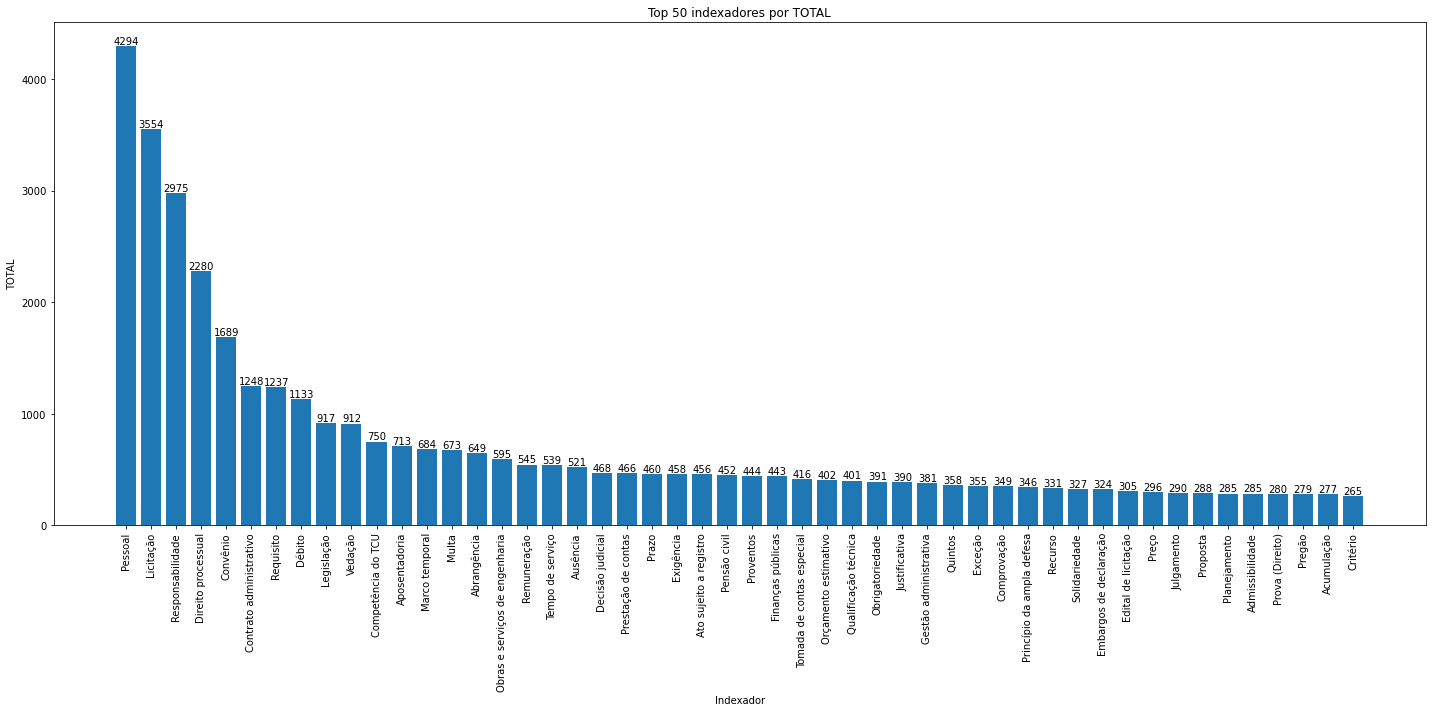

In [426]:
for property in list_property:
    if property == 'AREA':
        top_k = 10
    else:
        top_k = 50

    # Ordenar o DataFrame por 'TOTAL' em ordem decrescente
    df_sorted = df_index_docto.sort_values(by=property, ascending=False).iloc[:top_k]

    # Criar o gráfico de barras
    plt.figure(figsize=(20, 10))
    bars = plt.bar(df_sorted['NAME'], df_sorted[property])
    plt.title(f'Top {top_k} indexadores por {property}')
    plt.xlabel('Indexador')
    plt.ylabel(property)
    plt.xticks(rotation=90)
    plt.tight_layout()

    # Adicionar o valor na parte superior de cada barra
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')

    plt.show()


In [ ]:
df_index_docto[list_property].describe().round(2)

TYPE,AREA,TEMA,SUBTEMA,INDEXACAO_EXTRA,TOTAL
count,2853.00,2853.00,2853.00,2853.00,2853.00
mean,5.62,5.61,5.62,16.33,33.18
std,123.58,34.04,22.97,41.14,149.18
min,0.00,0.00,0.00,0.00,1.00
25%,0.00,0.00,0.00,1.00,2.00
50%,0.00,0.00,0.00,5.00,6.00
75%,0.00,0.00,1.00,15.00,23.00
max,4208.00,753.00,542.00,750.00,4294.00


33.18

In [452]:
print(f"Total de grupos de termos: {df_index_docto.shape[0]} tendo indexações:  mediana {df_index_docto[list_property].describe().round(2)['TOTAL']['50%']}  média {df_index_docto[list_property].describe().round(2)['TOTAL']['mean']}")  # Contar as ocorrências de cada lista de nomes


Total de grupos de termos: 2853 tendo indexações:  mediana 6.0  média 33.18


Ver conjuntos de indexações

In [427]:
# Agrupar o DataFrame por ID_QUERY e obter as listas de valores
df_index_query = df_index.groupby('ID_QUERY').agg({'NAME': lambda x: sorted(set(x))})


# Renomear as colunas
df_index_query = df_index_query.rename(columns={'NAME': 'LIST_NAME'})


In [428]:
df_index_query = df_index_query.reset_index()

In [429]:
# Criar o dicionário de mapeamento de valores
name_to_id_dict = dict(zip(df_doc['NAME'], df_doc['ID']))

# Mapear os valores em LIST_ID_DOCTO com base nos nomes em LIST_NAME
df_index_query['LIST_ID_DOCTO'] = df_index_query['LIST_NAME'].apply(lambda x: [name_to_id_dict[name] for name in x])



In [430]:
df_index_query.shape

(16022, 3)

In [431]:
df_index_query.head()

,ID_QUERY,LIST_NAME,LIST_ID_DOCTO
0,5,"[Aposentadoria-prêmio, Doença, Pensão especial, Pessoal, Proventos, Viúvo]","[15340, 15961, 1113, 1131, 1298, 5106]"
1,6,"[Cargo em comissão, Doença, Pensão especial, Pessoal, Viúvo]","[207, 15961, 1113, 1131, 5106]"
2,7,"[Arquivamento, Caso fortuito, Contas iliquidáveis, Direito processual, Força maior, Tomada de contas especial]","[108, 223, 1727, 5288, 650, 1526]"
3,8,"[Aposentadoria, Legislação, Pessoal, Reclassificação de cargo]","[92, 887, 1131, 1100820]"
4,9,"[Abrangência, Administração federal, Competência do TCU, Prestação de contas, Sociedade de economia mista]","[14715, 46, 5095, 1215, 1480]"


In [437]:
# assert df_doc[df_doc['ID'].isin(['ID_QUERY', 'LIST_NAME', 'LIST_ID_DOCTO'][df_index_query['ID_QUERY']==5]['LIST_ID_DOCTO'][0])].sort_values(by='NAME')['NAME'].values.tolist() == df_index_query[df_index_query['ID_QUERY']==5]['LIST_NAME'][0], 'Não está ok a ordenação!'

In [433]:
df_index_query['LIST_NAME'] = df_index_query['LIST_NAME'].apply(tuple)  # Converter a lista em tupla para torná-la hashable


In [435]:
df_index_query['COUNT_NAME'] = df_index_query['LIST_NAME'].apply(lambda x: len(x))


Número de termos

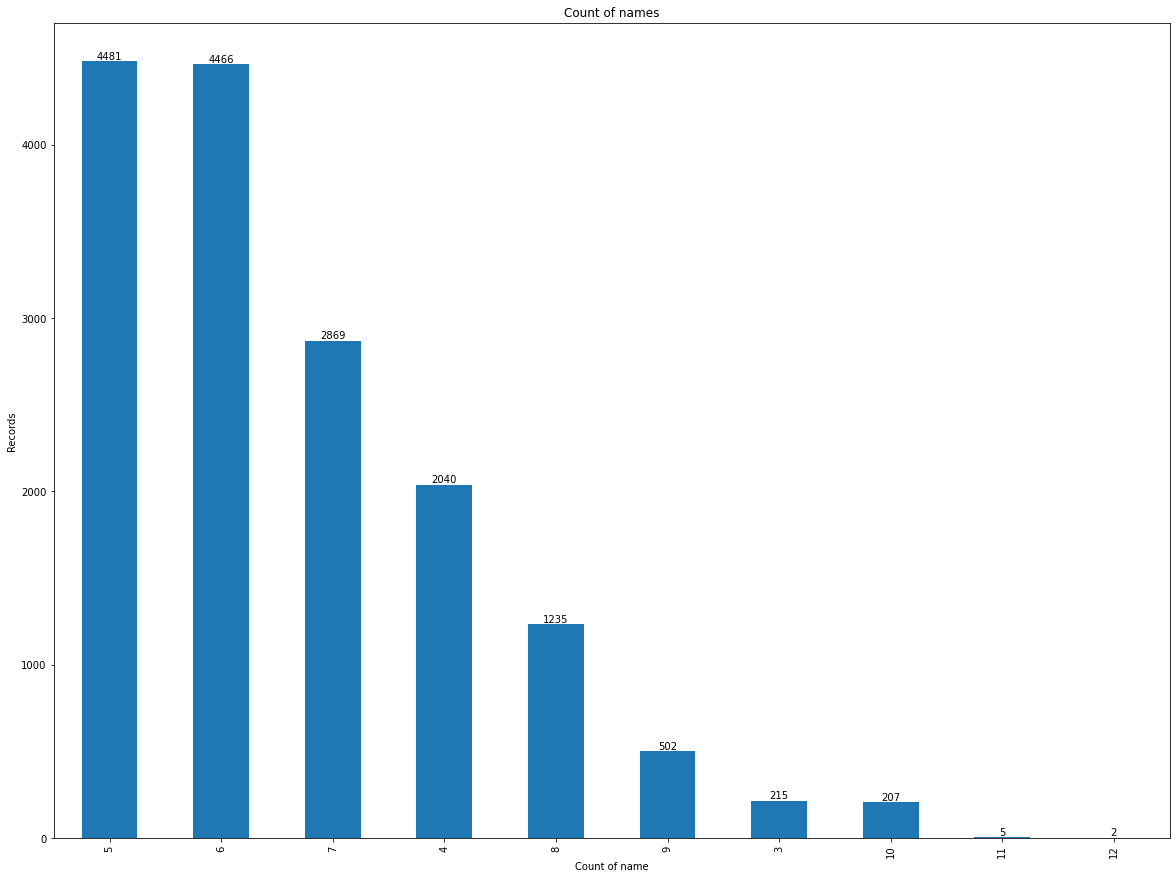

In [436]:
plt.figure(figsize=(20, 15))
counts = df_index_query['COUNT_NAME'].value_counts()
counts.plot(kind='bar')

plt.title('Count of names')
plt.xlabel('Count of name')
plt.ylabel('Records')

plt.xticks(rotation=90)

# Adicionar valor nas barras
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()


Mais usados

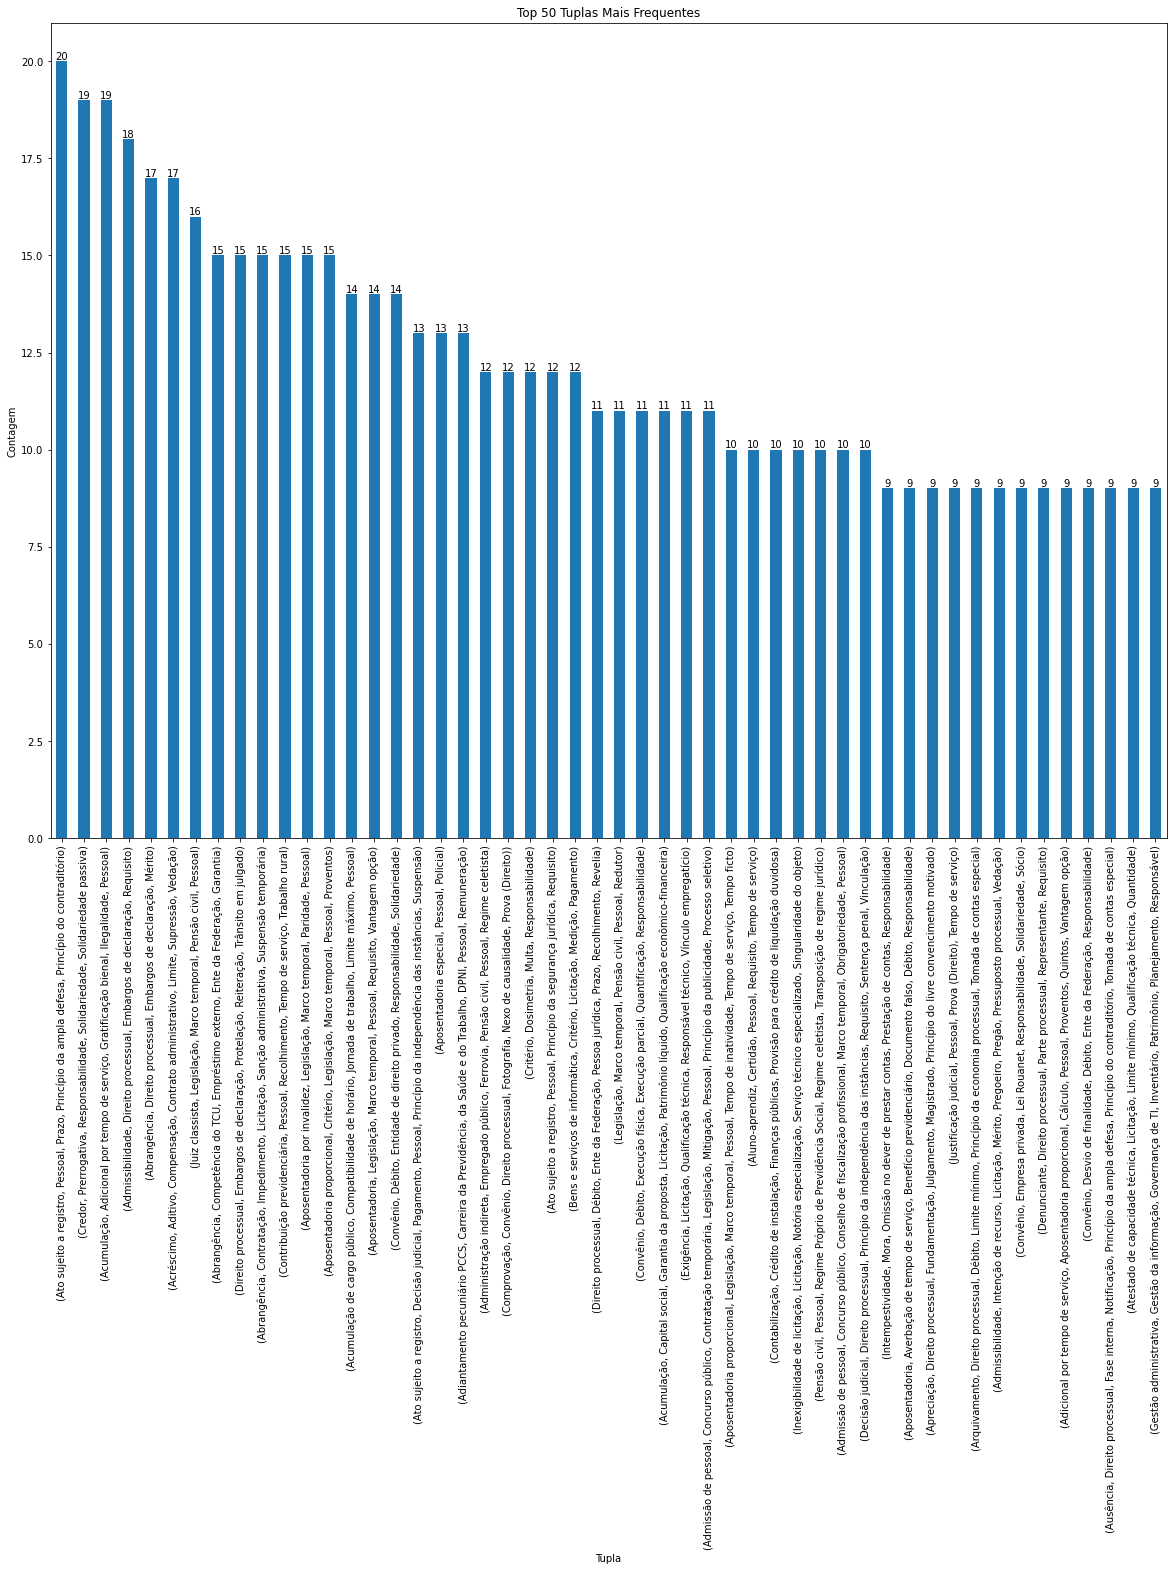

In [441]:
top_k = 50  # Defina o número de tuplas mais frequentes a serem exibidas

# Contar as ocorrências de cada tupla
count_by_name = df_index_query['LIST_NAME'].value_counts().head(top_k)

# Plotar o gráfico de barras
plt.figure(figsize=(20, 15))
count_by_name.plot(kind='bar')

plt.title(f'Top {top_k} Tuplas Mais Frequentes')
plt.xlabel('Tupla')
plt.ylabel('Contagem')

plt.xticks(rotation=90)

# Adicionar valor nas barras
for i, count in enumerate(count_by_name):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()


In [443]:
df_index_query['LIST_NAME'].value_counts().describe().round(2)

count    11881.00
mean         1.35
std          1.13
min          1.00
25%          1.00
50%          1.00
75%          1.00
max         20.00
Name: LIST_NAME, dtype: float64

In [453]:
print(f"Total de grupos de termos: {df_index_query['LIST_NAME'].value_counts().shape[0]} tendo indexações: em mediana {df_index_query['LIST_NAME'].value_counts().describe().round(2)['50%']},  em média {df_index_query['LIST_NAME'].value_counts().describe().round(2)['mean']}") 


Total de grupos de termos: 11881 tendo indexações: em mediana 1.0,  em média 1.35


# Exploration of DOCTO

Tamanho em tokens, palavras, etc

Termos usados em indexação: totais com/sem definição (etc)